<a href="https://colab.research.google.com/github/cmd-gunma-univ/DX-highschool/blob/main/Teachable_Machine%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

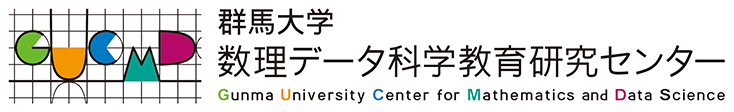

本デジタル教材の著作権は群馬大学数理データ科学教育研究センターに帰属します。

群馬大学出版会

Gunma University Press

TEL: 027-220-7180

# 機械学習(Teachable MachineとYOLO)

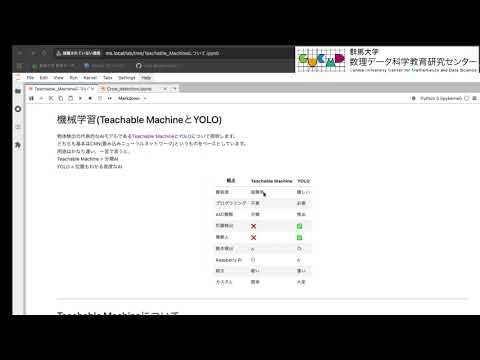

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo("FgwKRMduBs8", width=800, height=450)

物体検出の代表的なAIモデルである[Teachable Machine](https://teachablemachine.withgoogle.com/)と[YOLO](https://docs.ultralytics.com/ja/)について説明します。  
どちらも基本はCNN(畳み込みニューラルネットワーク)というものをベースとしています。  
用途はかなり違い、一言で言うと、  
Teachable Machine = 分類AI  
YOLO = 位置もわかる高度なAI  
| 観点 | Teachable Machine | YOLO |
|------|------------------|------|
| 難易度 | 超簡単 | 難しい |
| プログラミング | 不要 | 必要 |
| AIの種類 | 分類 | 検出 |
| 位置検出 | ❌ | ✅ |
| 複数人 | ❌ | ✅ |
| 動き検出 | △ | ◎ |
| Raspberry Pi | ◎ | △ |
| 軽さ | 軽い | 重い |
| カスタム | 簡単 | 大変 |



---
# Teachable Machineについて

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo("GT2h0QyYvTM", width=800, height=450)

[Teachable Machine](https://teachablemachine.withgoogle.com/)  
Teachable Machineは、Googleが提供するAI作成ツールで、プログラミングをしなくても画像・音声・姿勢などを使った機械学習モデルを簡単に作れるサービスです。自分でデータを集めて分類を学習させることで、身近な動きや物体を認識するAIを短時間で作成できます。作ったモデルはWebやスマートフォン、Raspberry Piなどで活用でき、教育や探究活動に適しています。  

グー、チョキ、パーの判定をすることを目的とし、以下の手順を説明します。  
1. ラズパイを使わず皆さんのPC上でモデルを作成  
2. 作成したモデルをラズパイ上で動かす

## 1. ラズパイを使わず皆さんのPC上でモデルを作成
カメラを繋いだPCを使って行う作業です。

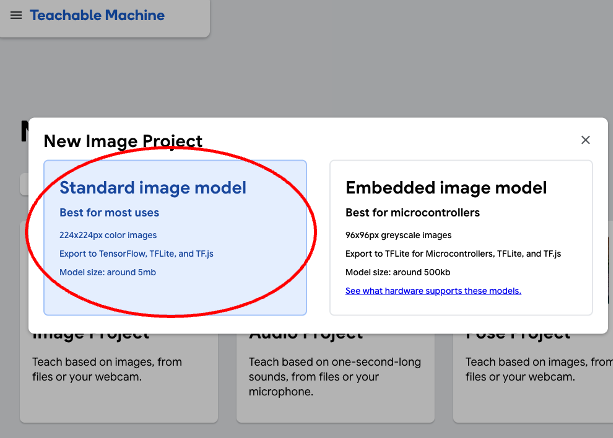

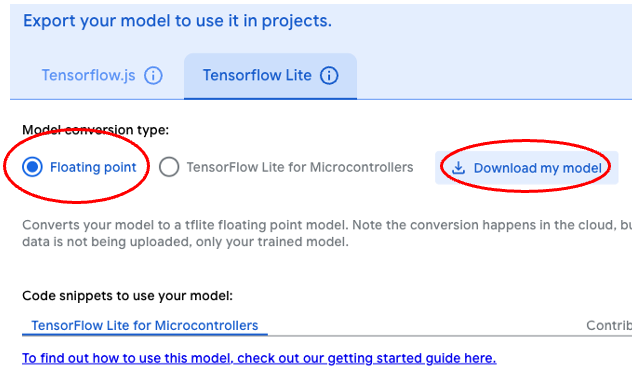

## 2. 作成したモデルをラズパイ上で動かす

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo("UODvv3mtmkY", width=800, height=450)

ダウンロードした`converted_tflite.zip`をラズパイにアップロードし、以下のコマンドで展開

In [ ]:
!unzip converted_tflite.zip

Archive:  converted_tflite.zip
 extracting: model_unquant.tflite    
 extracting: labels.txt              


In [ ]:
# Teachable Machine (TFLite) + USBカメラ（OpenCV）リアルタイム推論
# pip install tflite-runtime pillow numpy opencv-python

import cv2
import numpy as np
from PIL import Image
import tflite_runtime.interpreter as tflite
from IPython.display import display, Image as IPyImage, clear_output
import time

# =========================
# 設定
# =========================
MODEL_PATH  = "model_unquant.tflite"
LABELS_PATH = "labels.txt"

CAM_ID = 0
CAM_W, CAM_H = 320, 240   # カメラ解像度（重いなら 320x240 に）
SHOW_EVERY = 1            # 表示間引き（重いなら 2,3）
SLEEP = 0.0               # 0.02 など入れるとCPU負荷が下がる

# =========================
# ラベル読み込み
# =========================
with open(LABELS_PATH, "r", encoding="utf-8") as f:
    labels = [line.strip() for line in f if line.strip()]

# =========================
# TFLite interpreter
# =========================
interpreter = tflite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()

in_details  = interpreter.get_input_details()[0]
out_details = interpreter.get_output_details()[0]

_, H, W, C = in_details["shape"]  # だいたい (1,H,W,3)
in_dtype = in_details["dtype"]

print("Input shape:", in_details["shape"], "dtype:", in_dtype)
print("Output shape:", out_details["shape"], "dtype:", out_details["dtype"])

def preprocess_bgr(frame_bgr: np.ndarray) -> np.ndarray:
    """
    OpenCVのBGRフレーム -> モデル入力 (1,H,W,3)
    """
    # BGR -> RGB
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    # resize
    frame_rgb = cv2.resize(frame_rgb, (W, H), interpolation=cv2.INTER_AREA)

    x = frame_rgb.astype(np.float32)

    if in_dtype == np.float32:
        # Teachable Machine は [-1,1] が多い
        x = (x / 127.5) - 1.0
        x = x.astype(np.float32)
    else:
        # 量子化モデル(uint8など)ならそのまま
        x = x.astype(in_dtype)

    x = np.expand_dims(x, axis=0)
    return x

# =========================
# カメラ開始
# =========================
cap = cv2.VideoCapture(CAM_ID)
if not cap.isOpened():
    raise RuntimeError("カメラが開けませんでした。/dev/video0 等を確認してください。")

cap.set(cv2.CAP_PROP_FRAME_WIDTH,  CAM_W)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, CAM_H)

frame_i = 0

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("フレーム取得に失敗")
            break

        # ---- 推論 ----
        x = preprocess_bgr(frame)
        interpreter.set_tensor(in_details["index"], x)
        interpreter.invoke()
        y = interpreter.get_tensor(out_details["index"])[0]

        top = int(np.argmax(y))
        score = float(y[top])
        label = labels[top] if top < len(labels) else f"class_{top}"

        # ---- 画面に描画 ----
        show = frame.copy()
        cv2.putText(show, f"{label}  {score:.2f}", (10, 35),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)

        # ---- Jupyterに表示（同じ場所で更新）----
        frame_i += 1
        if frame_i % SHOW_EVERY == 0:
            ok, jpg = cv2.imencode(".jpg", show, [int(cv2.IMWRITE_JPEG_QUALITY), 75])
            if ok:
                clear_output(wait=True)
                display(IPyImage(data=jpg.tobytes()))

        if SLEEP > 0:
            time.sleep(SLEEP)

except KeyboardInterrupt:
    print("停止")

finally:
    cap.release()
    print("カメラ解放")

## 練習問題
あなたの笑顔、悲しい顔、真顔の３種類を区別するモデルをTeachable Machineで作成し、ラズパイに実装しなさい。
また笑顔を検知している時にLEDを点灯させなさい。